###PROJECT STATEMENT : Predicting the future value of a customer to a business over the entire duration of their relationship, incorporating factors such as past purchase history, frequency of purchases, and customer demographics.

####CSI ID : CT_CSI_DS_5488
Domian :Data Science

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
xls = pd.ExcelFile("online_retail_II.xlsx")
df_2009 = xls.parse("Year 2009-2010", dtype={'Customer ID': str})
df_2010 = xls.parse("Year 2010-2011", dtype={'Customer ID': str})
df = pd.concat([df_2009, df_2010], ignore_index=True)

print(df.shape)
df.head()


(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [ ]:
df = df.dropna(subset=["Customer ID", "Invoice"]).copy()
df = df[~df['Invoice'].astype(str).str.startswith('C')].copy()
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['Price']
df.reset_index(drop=True, inplace=True)


In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,5633.32
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40


In [ ]:
features = rfm.copy()
features['AvgOrderValue'] = features['Monetary'] / features['Frequency']
features.head()


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue
0,12346,326,12,77556.46,6463.038333
1,12347,2,8,5633.32,704.165000
2,12348,75,5,2019.40,403.880000
3,12349,19,4,4428.69,1107.172500
4,12350,310,1,334.40,334.400000


In [ ]:
purchase_dates = df.groupby('Customer ID')['InvoiceDate'].apply(list)
features['AvgDaysBetweenPurchases'] = purchase_dates.apply(
    lambda dates: np.mean(np.diff(sorted(dates))).days if len(dates) > 1 else np.nan
)
features = features.dropna()  # Optional: remove customers with only one purchase
features.head()


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,AvgDaysBetweenPurchases


In [ ]:
# Recalculate RFM and all features
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Add TotalUnitsBought and AvgPricePerUnit
total_units = df.groupby('Customer ID')['Quantity'].sum().reset_index()
total_units.columns = ['CustomerID', 'TotalUnitsBought']

# Merge
features = pd.merge(rfm, total_units, on='CustomerID')
features['AvgPricePerUnit'] = features['Monetary'] / features['TotalUnitsBought']

# Drop any remaining nulls
features.dropna(inplace=True)

# Prepare input/output for model
X = features[['Recency', 'Frequency', 'AvgOrderValue', 'TotalUnitsBought', 'AvgPricePerUnit']]
y = features['Monetary']

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X shape: (5881, 5)
y shape: (5881,)


In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 556.5740621750214
RMSE: 11196.435757829775
R2 Score: 0.6415657776094271


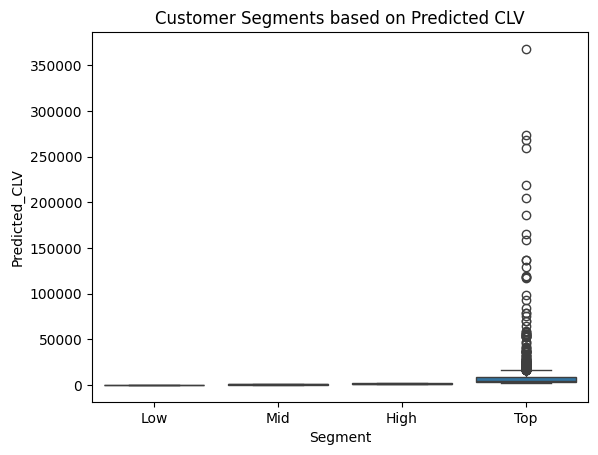

In [ ]:
features['Predicted_CLV'] = model.predict(X)
features['Segment'] = pd.qcut(features['Predicted_CLV'], q=4, labels=['Low', 'Mid', 'High', 'Top'])

sns.boxplot(data=features, x='Segment', y='Predicted_CLV')
plt.title("Customer Segments based on Predicted CLV")
plt.show()


In [ ]:
new_customer = pd.DataFrame([{
    'Recency': 20,
    'Frequency': 10,
    'AvgOrderValue': 25,
    'TotalUnitsBought': 100,
    'AvgPricePerUnit': 2.5
}])

predicted_value = model.predict(new_customer)[0]
print(f"Predicted CLV for new customer: ₹{int(predicted_value)}")


Predicted CLV for new customer: ₹187


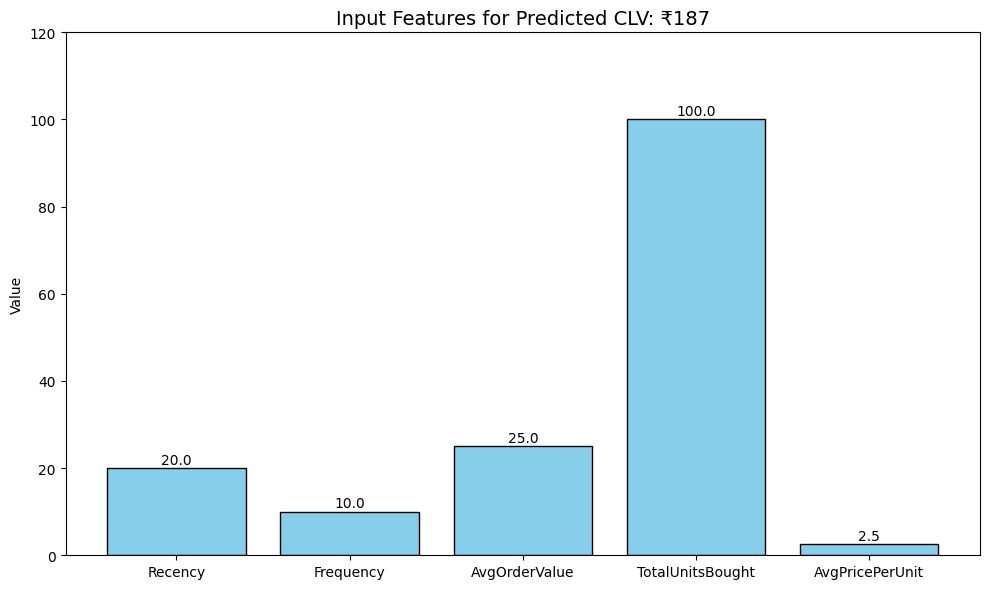

In [ ]:
features_list = ['Recency', 'Frequency', 'AvgOrderValue', 'TotalUnitsBought', 'AvgPricePerUnit']
values = new_customer.iloc[0].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(features_list, values, color='skyblue', edgecolor='black')
plt.title(f'Input Features for Predicted CLV: ₹{int(predicted_value)}', fontsize=14)
plt.ylabel('Value')
plt.ylim(0, max(values) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center')

plt.tight_layout()
plt.show()
